In [ ]:
# En caso de problemas, utilizar las dependencias de librerías de este requierement: https://github.com/googlecolab/backend-info/blob/d6d345cb94fc5fd49951c9af0f6ead5e962bfab2/pip-freeze.txt
!pip install numpy==1.23.5
!pip install transformers[torch]==4.35.2
!pip install accelerate -U
!pip install evaluate

In [2]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

**En este ejercicio debeis entrenar un modelo de clasificación utilizando la librería Transformers.** Dado que el análisis exploratorio ha sido realizado en el ejercicio anterior, en este caso podréis centraros en entrenar el modelo utilizando la librería Transformers, seleccionando un modelo pre-entrenado adecuado, entrenando el modelo y llevando a cabo la evaluación.


**Nota 1**: Este ejercicio requiere el uso de las GPUs de Google Colab. Este Colab debería estar preconfigurado para ejecutarse en GPU, pero si tuviera problemas en la ejecución que me contacte a través del Moodle para buscar soluciones alternativas.

## 0. Imports


In [3]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW
)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [4]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [5]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

Podéis saltarlo en este ejercicio.

## 3. Preprocesado y Normalización

Para comenzar con nuestro ejercicio de Modelos de Lenguaje, debo dividir el dataset para llevar a caso el proceso.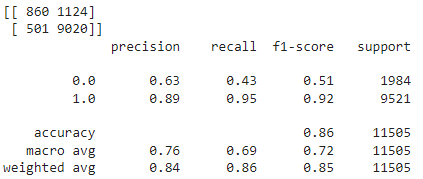

In [6]:
texts = dataset.tweet_text.values
labels = dataset.cyberbullying.values

Procedo a dividir y hacer el muestreo del conjunto de datos que poseo en Train_validation aplicando sobre un 90% y un 10% de test.

In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts,
                                                                      labels,
                                                                      test_size=.25,
                                                                      random_state=0,
                                                                      stratify = labels)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts,
                                                                    train_labels,
                                                                    test_size=.2,
                                                                    random_state=0,
                                                                    stratify = train_labels)

Cuando se emplea la librería Transformers, es crucial adaptar nuestros datos al formato que el modelo preentrenado requiere. Cada uno de estos modelos cuenta con un tokenizador diseñado específicamente para segmentar los textos de la forma más adecuada para su procesamiento. En este momento, es necesario seleccionar el modelo preentrenado que utilizaremos para tratar nuestros textos. Para elegir el modelo adecuado, podemos explorar el hub de modelos de HuggingFace.

En mi caso, he decidido entrar en Models - Hugging Face, como se que vienen de twitter los datos, modelos de lenguaje, selecciono modelos base que son los Fill-Mask y he tratado de seleccionar uno de cardiff que son los que mejor funcionan, por lo tanto, escogi: bert-base-uncased.

In [8]:
model_name = "bert-base-uncased"

Ahora, podria cargar nuestro Tokenizador utilizando la clase AutoTokenizer.

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Ahora comprobaré como el tokenizador subdivide un texto de ejemplo:

In [10]:
texto = "Cats and gods love each to other as a brothers"
texto_tokens = tokenizer(texto).tokens()
texto_tokens

['[CLS]',
 'cats',
 'and',
 'gods',
 'love',
 'each',
 'to',
 'other',
 'as',
 'a',
 'brothers',
 '[SEP]']

Es notorio que los caracteres [CLS] y [SEP] marcan, respectivamente, el comienzo y el fin de una frase. Estos caracteres específicos son utilizados para señalar el inicio y conclusión de frases en los modelos que emplean la arquitectura Bert.

## 4. Vectorización

Además, para utilizar eficazmente el ecosistema de HuggingFace, es fundamental importar los datos conforme a la estructura que emplea la librería Datasets, la cual se basa en un formato columnar establecido por el proyecto Apache Arrow.

Los datasets pueden obtenerse directamente desde el repositorio de HuggingFace o se pueden ajustar datos propios al formato Dataset usando funciones designadas para tal fin. Para este propósito, emplearemos una clase denominada CustomDataset(), que recibirá como entrada los textos y las etiquetas de cada subconjunto de datos y los adaptará al formato necesario para el entrenamiento, realizando la tokenización de manera interna.

In [11]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Constructor de la clase CustomDataset.
        Parámetros:
        - texts: Lista de textos.
        - labels: Lista de etiquetas correspondientes a los textos.
        - tokenizer: Objeto del tokenizador a utilizar.
        - max_length: Longitud máxima de la secuencia después de la tokenización.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Devuelve la longitud del conjunto de datos.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Obtiene un elemento del conjunto de datos.

        Parámetros:
        - idx: Índice del elemento a obtener.

        Devuelve:
        Un diccionario con 'input_ids', 'attention_mask' y 'labels'.
        """
        # Obtener el texto y la etiqueta del índice proporcionado
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenizar el texto
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Devolver el diccionario con los datos
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


Transformare mis datos al formato datasets

In [12]:
max_length = 128

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)

Observaremos que cada elemento del nuevo formato contendrá:

inputs_ids: Son identificadores numéricos que representan los tokens según el vocabulario del modelo.
attention_mask: Un vector que señala a la red neuronal las partes de la secuencia de entrada a las que debe atender y las que debe omitir.
labels: Este campo alberga la etiqueta correspondiente al texto.

In [13]:
train_dataset[20]

{'input_ids': tensor([  101,  2027,  1005,  2128,  2725,  1996,  4438,  2082, 20716,  5248,
          1012,  2725,  2035,  2027,  2064,  2000,  2131,  2111,  1999,  4390,
          1998,  2131,  2185,  2007,  2009,  2011,  7302,  3093,  2012,  1996,
          7036,  1998,  2667,  2000,  2377,  1996,  7499,  2208,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

Antes de procesar las entradas, es crucial establecer la longitud de la secuencia (la máxima longitud del documento en términos de tokens) y el tamaño del lote (batch size). En Colab, enfrentamos ciertas restricciones (batch = 8 y secuencia = 96). Aunque es posible aumentar la longitud de la secuencia disminuyendo el tamaño del lote, en esta situación, esa modificación no nos afecta significativamente.

In [14]:
max_seq_length = 96
train_batch_size =  8
eval_batch_size = 8
test_batch_size = 8

## 5. Entrenamiento y evaluación de modelos


Para proceder con el entrenamiento, necesitamos cargar el modelo en el entorno de ejecución. Utilizaremos la clase AutoModelForSequenceClassification(), diseñada para cargar modelos que se ajustarán para la clasificación de secuencias de textos.

En esta clase, especificaremos la cantidad de etiquetas que manejamos en nuestro problema de clasificación (que son 2 en este caso), y añadiremos unos diccionarios que nos ayudarán a manejar y comprender mejor las salidas del modelo.

In [15]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "No_cyberbullying", 1: "Cyberbullying"}
label2id = {"No_cyberbullying": 0, "Cyberbullying": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Definiré algunos parámetros necesarios para llevar a cabo el entrenamiento.

In [16]:
import accelerate

training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

Generó una función de cálculo de métricas de evaluación durante el entrenamiento.

In [17]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

Creo el objeto Trainer(), que me permita llevar a cabo y ejecutar el ajuste del modelo.

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [19]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.253400,0.250515,{'accuracy': 0.8943248532289628},{'f1': 0.9387457462323773}


Trainer is attempting to log a value of "{'accuracy': 0.8943248532289628}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9387457462323773}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=3577, training_loss=0.28243243884267105, metrics={'train_runtime': 765.7582, 'train_samples_per_second': 37.368, 'train_steps_per_second': 4.671, 'total_flos': 1882230712281600.0, 'train_loss': 0.28243243884267105, 'epoch': 1.0})

**Evaluación**

Después de entrenar el modelo, procederemos a su evaluación.

El objeto Trainer() cuenta con un método .evaluate(), que facilita la introducción de un conjunto de datos de evaluación y permite obtener las métricas de accuracy y f1 que se definieron anteriormente.

In [20]:
trainer.evaluate(test_dataset)

Trainer is attempting to log a value of "{'accuracy': 0.893315440744779}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9381142356718887}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.25610971450805664,
 'eval_accuracy': {'accuracy': 0.893315440744779},
 'eval_f1_score': {'f1': 0.9381142356718887},
 'eval_runtime': 87.8961,
 'eval_samples_per_second': 135.649,
 'eval_steps_per_second': 16.963,
 'epoch': 1.0}

También realizaremos un informe de clasificación para observar los puntajes relativos a cada categoría. Para ello, utilizaremos el método .predict() para predecir las etiquetas en el conjunto de prueba. Luego, extraeremos la etiqueta correspondiente de cada predicción.

In [21]:
predictions = trainer.predict(test_dataset)

In [22]:
predictions[0][0]

array([-3.1526096,  2.8488762], dtype=float32)

In [23]:
y_pred = predictions.predictions.argmax(axis=1)

Utilizo las etiquetas verdaderas y calculamos el classification report

In [24]:
y_true = [x["labels"].item() for x in test_dataset]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[1010  976]
 [ 296 9641]]
              precision    recall  f1-score   support

           0       0.77      0.51      0.61      1986
           1       0.91      0.97      0.94      9937

    accuracy                           0.89     11923
   macro avg       0.84      0.74      0.78     11923
weighted avg       0.89      0.89      0.88     11923



Podemos contrastar los resultados con los obtenidos mediante un clasificador que emplea ingeniería de características, evaluando las métricas de precisión, recall, f1-score y soporte.

[[ 860 1124]
 [ 501 9020]]
              precision    recall  f1-score   support

         0.0       0.63      0.43      0.51      1984
         1.0       0.89      0.95      0.92      9521

     accuracy                           0.86     11505
     macro avg       0.76      0.69      0.72     11505
     weighted avg       0.84      0.86      0.85     11505

Como podemos ver, comparando con los resultados obtenidos del ejercicio 1, basicamente mi modelo mejora en casi todas las metricas, en cuanto a la precision tanto la categoria 0 y 1, han aumentado muchisimo, con mayor crecimiento la de "No Cyberbullying" que paso de un 0.63 a un 0.74. y en las metricas de recall y f1 tambien mejora esta categoria 0.

La categoria 1 mejora, pero no tan notoriamente como la 0. Por lo que podemos concluir, que el modelo mejora y se ajusta muy bien.

También podemos predecir cualquier frase o tweet que quisiéramos de forma sencilla.

In [26]:
# Create a function to predict for a single document
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_single_document(document, max_length=128):
    # Tokenize the input document
    inputs = tokenizer(document, return_tensors="pt", max_length=max_length, truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to the same device as the model

    # Make the prediction
    with torch.no_grad():
      model_output = trainer.model(**inputs)

    # Access the predicted labels
    predicted_label = torch.argmax(model_output.logits).item()

    return predicted_label

In [27]:
#Escribe el texto que quieras clasificar
input_text1 = 'I hate you'
input_text2 = 'I feel so lucky to have you in my life, I love you'

pred1 = predict_single_document(input_text1)
pred2 = predict_single_document(input_text2)

# label_mapping = {0:"no molesto",1:"molesto"}

print("Clase texto 1: {}".format(pred1))
print("Clase texto 2: {}".format(pred2))

Clase texto 1: 1
Clase texto 2: 0
